## Assignment 2 - Logistic Regression

SPPH 500 - Ly Trinh

In [78]:
library(tidyverse)
library(glmnet)
library(leaps)
library(bestglm)

Warning message:
"package 'leaps' was built under R version 3.6.3"Warning message:
"package 'bestglm' was built under R version 3.6.3"

Gardasil (Merck & Co.) has been available since 2006, and has been shown to successfully prevent certain types of human papillomavirus (HPV).  The vaccine is most effective if the 3-shot regimen is completed within a 1-year period. However, the adoption of this vaccine for preventing HPV has been  slow. This is despite the FDA’s recommendation for vaccination prior to adolescence and sexual activity. The gardasil.csv dataset gives characteristics of young female patients between the ages of 11 and 26 who came to clinics of Johns Hopkins Medical Institutions between 2006 and 2008 to begin the three-shot regimen of vaccinations with Gardasil. 

VARIABLE DESCRIPTIONS

Age: Age in years \
Race: 0 = White, 1 = Black, 2 = Hispanic, 3 = Other/unknown \
Shots: Number of shots the patient completed (in total) \
Completed: 0 = Did not complete shots, 1 = Completed shots (in 1-year period) \
InsuranceType: 0 = Medical assistance, 1 = Private payer (Blue Cross, Blue Shield, Aetna, Cigna, United,
Commercial, CareFirst), 2 = Hospital based (EHF), 3 = Military (USFHP, Tricare, MA) \
Location: 1 = Odenton, 2 = White Marsh, 3 = Johns Hopkins Outpatient Centre, 4 = Bayview \
LocationType: 0 = Suburban, 1 = Urban \
PracticeType: 0 = Pediatric, 1 = Family practice, 2 = OB-GYN

Build a model to predict whether or not an individual will complete the 3-shot regimen of vaccination within the recommended 12-month period.  Make sure to clearly outline how you chose your final model, and a reason for including/excluding each variable.  Also, provide some measure (you may choose what you like) of the predictive power of the model. 

In [105]:
# load data
gardasil <- read.csv('./gardasil.csv')

In [106]:
head(gardasil)

Age,Race,Shots,Completed,InsuranceType,Location,LocationType,PracticeType
21,0,3,1,3,1,0,1
21,0,3,1,3,1,0,1
20,0,1,0,1,1,0,1
14,0,3,1,3,1,0,0
17,3,2,0,3,1,0,1
11,1,1,0,0,1,0,0


In [107]:
dim(gardasil)

[1] 1413    8

In [108]:
summary(gardasil)

      Age             Race           Shots         Completed     
 Min.   :11.00   Min.   :0.000   Min.   :1.000   Min.   :0.0000  
 1st Qu.:15.00   1st Qu.:0.000   1st Qu.:1.000   1st Qu.:0.0000  
 Median :18.00   Median :0.000   Median :2.000   Median :0.0000  
 Mean   :18.55   Mean   :0.782   Mean   :2.069   Mean   :0.3319  
 3rd Qu.:22.00   3rd Qu.:1.000   3rd Qu.:3.000   3rd Qu.:1.0000  
 Max.   :26.00   Max.   :3.000   Max.   :3.000   Max.   :1.0000  
 InsuranceType      Location      LocationType     PracticeType  
 Min.   :0.000   Min.   :1.000   Min.   :0.0000   Min.   :0.000  
 1st Qu.:1.000   1st Qu.:1.000   1st Qu.:0.0000   1st Qu.:0.000  
 Median :1.000   Median :1.000   Median :0.0000   Median :1.000  
 Mean   :1.333   Mean   :2.009   Mean   :0.3185   Mean   :1.013  
 3rd Qu.:2.000   3rd Qu.:4.000   3rd Qu.:1.0000   3rd Qu.:2.000  
 Max.   :3.000   Max.   :4.000   Max.   :1.0000   Max.   :2.000  

In [109]:
# change categorical vars to factors
gardasil <- gardasil %>%
    mutate_at(vars(c("Race","Completed", "InsuranceType", 
                     "Location", "LocationType", "PracticeType")),
             as.factor)
summary(gardasil)

      Age        Race        Shots       Completed InsuranceType Location
 Min.   :11.00   0:732   Min.   :1.000   0:944     0:275         1:798   
 1st Qu.:15.00   1:443   1st Qu.:1.000   1:469     1:723         2:165   
 Median :18.00   2: 52   Median :2.000             2: 84         3: 89   
 Mean   :18.55   3:186   Mean   :2.069             3:331         4:361   
 3rd Qu.:22.00           3rd Qu.:3.000                                   
 Max.   :26.00           Max.   :3.000                                   
 LocationType PracticeType
 0:963        0:515       
 1:450        1:365       
              2:533       
                          
                          
                          

In [110]:
# is completing three shots (Shots==3) the same as Completed==1?
gardasil %>%
    count(Completed, Shots)

Completed,Shots,n
0,1,440
0,2,436
0,3,68
1,3,469


In [111]:
#remove Shots, since completed group did not have anyone with 1 or 2 shots

In [112]:
# are the clinics divided evenly?
gardasil %>%
    count(Location, LocationType)

Location,LocationType,n
1,0,798
2,0,165
3,1,89
4,1,361


#collinear, remove one

In [113]:
#remove shots
gardasil <- gardasil %>%
    select(-Shots, -LocationType)

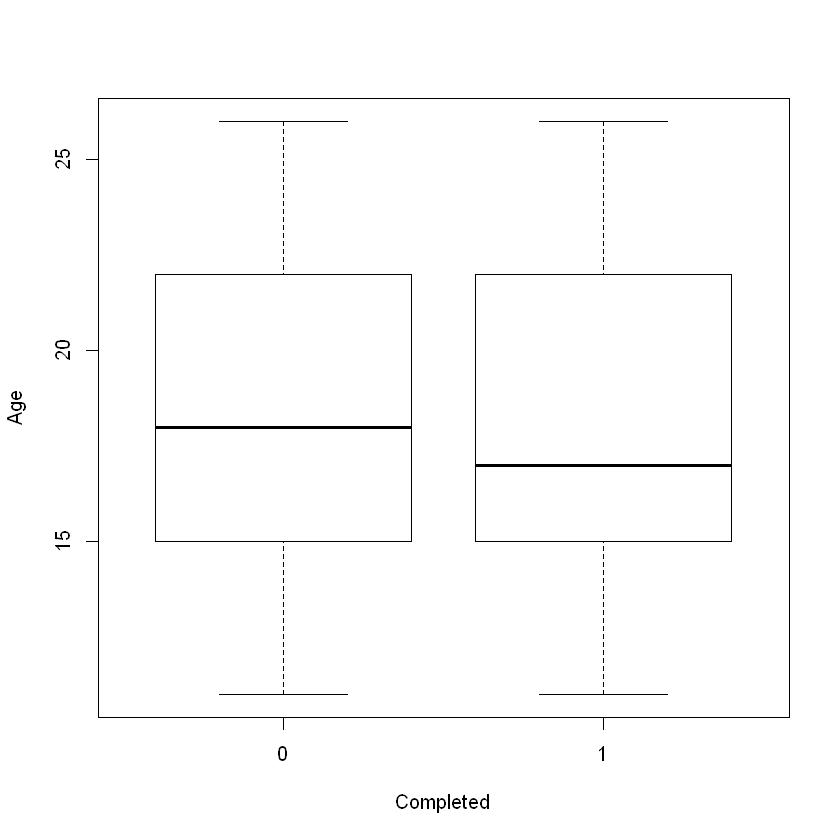

In [140]:
# explore interactions with age
par(mfrow=c(2,2))
boxplot(Age~Completed,data=gardasil)
barplot()

### Try lasso

In [167]:
# create train and test set on a 80-20 rule
set.seed(123)
train_ids <- sample(1:nrow(gardasil), nrow(gardasil)*.8, replace=F)

train_df <- gardasil[train_ids,]
test_df <- gardasil[-train_ids,]

# dummy coding for predictors
train_x <- model.matrix(Completed~.+Age*.+Race*., train_df)[,-1]
train_y <- train_df$Completed

test_x <- model.matrix(Completed~.+Age*.+Race*., test_df)[,-1]
test_y <- test_df$Completed

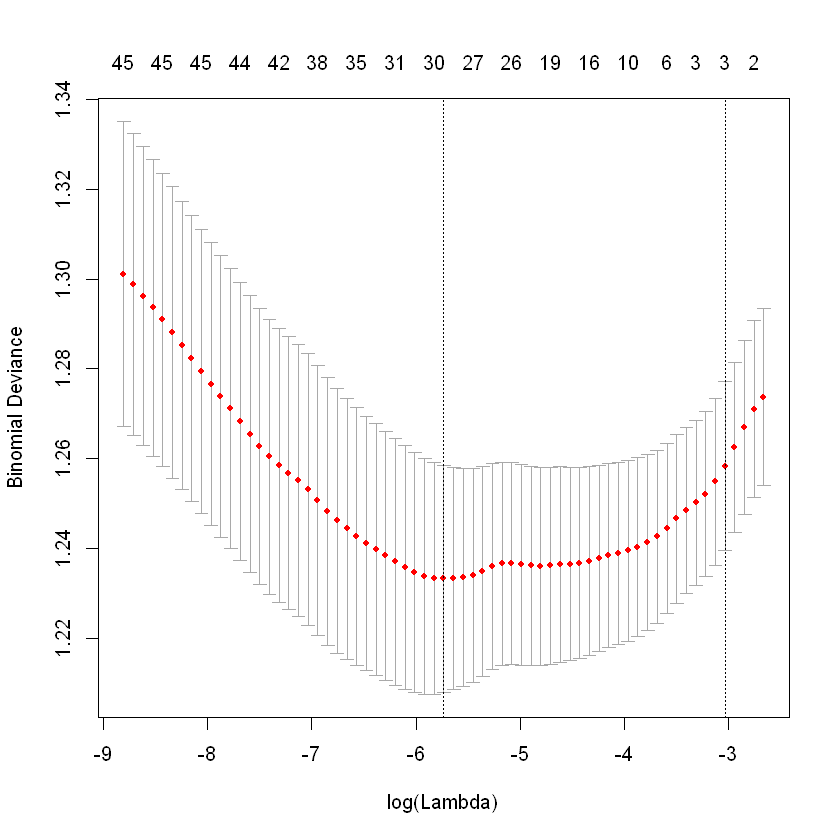

In [168]:
# lasso
# cv to find the best lambda
set.seed(1234)
cv.lasso <- cv.glmnet(train_x, train_y, alpha=1, family="binomial")
plot(cv.lasso)

In [169]:
cv.lasso$lambda.min
cv.lasso$lambda.1se

[1] 0.003237567

[1] 0.04807684

In [170]:
coef(cv.lasso, cv.lasso$lambda.min)

48 x 1 sparse Matrix of class "dgCMatrix"
                               1
(Intercept)           0.72878290
Age                  -0.09951845
Race1                -0.21499194
Race2                 .         
Race3                 .         
InsuranceType1        .         
InsuranceType2        .         
InsuranceType3        0.35745822
Location2             .         
Location3            -0.36731830
Location4            -1.13144742
PracticeType1         .         
PracticeType2         .         
Age:Race1             .         
Age:Race2             .         
Age:Race3             .         
Age:InsuranceType1    0.02680928
Age:InsuranceType2    0.04906488
Age:InsuranceType3    .         
Age:Location2         0.01288445
Age:Location3        -0.05275525
Age:Location4         0.06306274
Age:PracticeType1     .         
Age:PracticeType2     0.02403279
Race1:InsuranceType1  .         
Race2:InsuranceType1  .         
Race3:InsuranceType1  .         
Race1:InsuranceType2  0.11449667
R

In [171]:
coef(cv.lasso, cv.lasso$lambda.1se)

48 x 1 sparse Matrix of class "dgCMatrix"
                              1
(Intercept)          -0.6568107
Age                   .        
Race1                -0.1101256
Race2                 .        
Race3                 .        
InsuranceType1        .        
InsuranceType2        .        
InsuranceType3        .        
Location2             0.1370961
Location3             .        
Location4             .        
PracticeType1         .        
PracticeType2         .        
Age:Race1             .        
Age:Race2             .        
Age:Race3             .        
Age:InsuranceType1    .        
Age:InsuranceType2    .        
Age:InsuranceType3    .        
Age:Location2         .        
Age:Location3         .        
Age:Location4         .        
Age:PracticeType1     .        
Age:PracticeType2     .        
Race1:InsuranceType1  .        
Race2:InsuranceType1  .        
Race3:InsuranceType1  .        
Race1:InsuranceType2  .        
Race2:InsuranceType2  .       

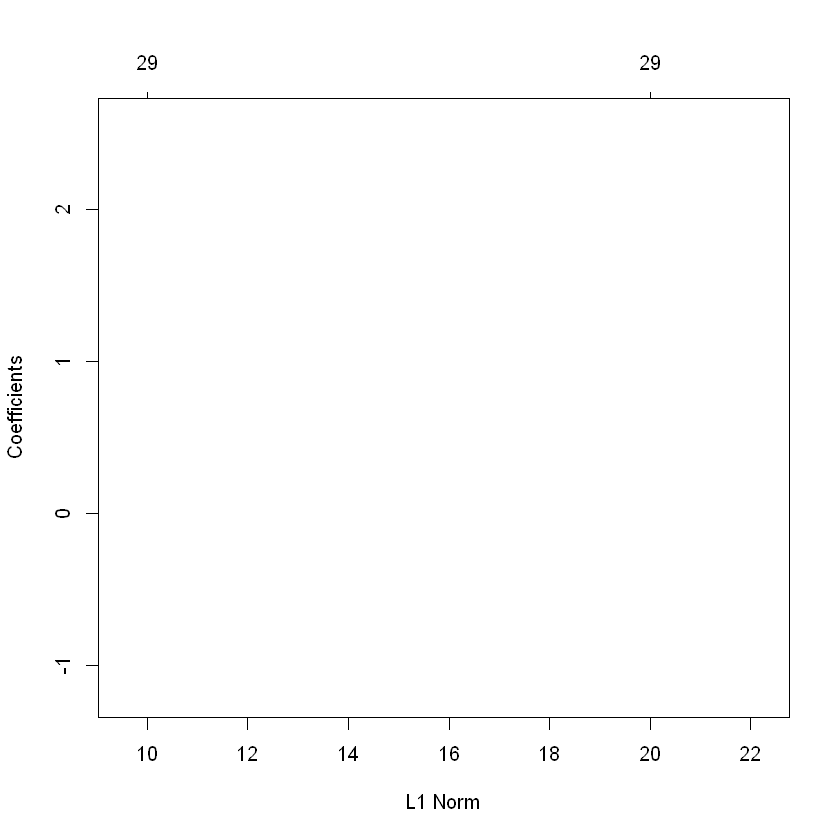

In [172]:
# final model with lambda min
lasso_mod1 <- glmnet(train_x, train_y, alpha=1, family="binomial", lambda = cv.lasso$lambda.min)
plot(lasso_mod1)

In [173]:
# make prediction on test data
preds <- predict(lasso_mod1, newx = test_x, type="response")
preds_class <- ifelse(preds> 0.5, 1, 0)
# preds

#predictive accuracy, 2x2 table
table(preds_class, test_y)

           test_y
preds_class   0   1
          0 180  79
          1  10  14

In [174]:
mean(preds_class==test_y)

[1] 0.6855124

In [175]:
# final model with lambda 1se
lasso_mod2 <- glmnet(train_x, train_y, alpha=1, family="binomial", lambda = cv.lasso$lambda.1se)

# make prediction on test data
preds2 <- predict(lasso_mod2, newx = test_x, type="response")
preds_class2 <- ifelse(preds2> 0.5, 1, 0)
# preds

#predictive accuracy, 2x2 table
table(preds_class2, test_y)

            test_y
preds_class2   0   1
           0 190  93

## Full logreg model

In [158]:
lg_mod1 <- glm(Completed~., data=train_df, family=binomial(link="logit"))
summary(lg_mod1)


Call:
glm(formula = Completed ~ ., family = binomial(link = "logit"), 
    data = train_df)

Deviance Residuals: 
    Min       1Q   Median       3Q      Max  
-1.6079  -0.9176  -0.7166   1.2706   2.2489  

Coefficients:
               Estimate Std. Error z value Pr(>|z|)    
(Intercept)     0.15740    0.41385   0.380 0.703699    
Age            -0.06372    0.02123  -3.001 0.002690 ** 
Race1          -0.54958    0.16269  -3.378 0.000730 ***
Race2           0.08319    0.36256   0.229 0.818516    
Race3          -0.02815    0.20297  -0.139 0.889703    
InsuranceType1  0.56507    0.23613   2.393 0.016709 *  
InsuranceType2  1.19754    0.33054   3.623 0.000291 ***
InsuranceType3  0.51038    0.27616   1.848 0.064585 .  
Location2       0.23902    0.23652   1.011 0.312228    
Location3      -0.79393    0.37461  -2.119 0.034060 *  
Location4      -0.41003    0.22694  -1.807 0.070803 .  
PracticeType1  -0.22022    0.21884  -1.006 0.314273    
PracticeType2   0.39719    0.23622   1.681 0.09268

In [179]:
lg_preds1 <- predict(lg_mod1, newdata=test_df, type="response")

lg_class1 <- ifelse(lg_preds1 > 0.5, 1, 0)

table(lg_class1, test_y)
mean(lg_class1==test_y)

         test_y
lg_class1   0   1
        0 175  78
        1  15  15

[1] 0.6713781

In [163]:
# try logistic with interactions
lg_mod2 <- glm(Completed~.+Age*.+Race*., data=train_df, family=binomial(link="logit"))
summary(lg_mod2)


Call:
glm(formula = Completed ~ . + Age * . + Race * ., family = binomial(link = "logit"), 
    data = train_df)

Deviance Residuals: 
    Min       1Q   Median       3Q      Max  
-1.7123  -0.8985  -0.6461   1.1492   2.3565  

Coefficients:
                       Estimate Std. Error z value Pr(>|z|)    
(Intercept)            4.789889   1.490447   3.214 0.001310 ** 
Age                   -0.345037   0.090269  -3.822 0.000132 ***
Race1                 -1.212286   1.030346  -1.177 0.239363    
Race2                  2.318430   3.786074   0.612 0.540301    
Race3                 -1.169871   1.466926  -0.797 0.425162    
InsuranceType1        -0.515069   1.133459  -0.454 0.649525    
InsuranceType2        -1.034387   1.814829  -0.570 0.568702    
InsuranceType3         0.086344   1.399371   0.062 0.950800    
Location2              0.634343   1.486681   0.427 0.669609    
Location3              0.196143   2.979554   0.066 0.947513    
Location4             -4.085322   1.088870  -3.752 0.

In [165]:
lg_preds2 <- predict(lg_mod2, newdata=test_df, type="response")
lg_class2 <- ifelse(lg_preds2 > 0.5, 1, 0)

table(lg_class2, test_y)
mean(lg_class2==test_y)

         test_y
lg_class2   0   1
        0 166  65
        1  24  28

[1] 0.6855124

## Ridge

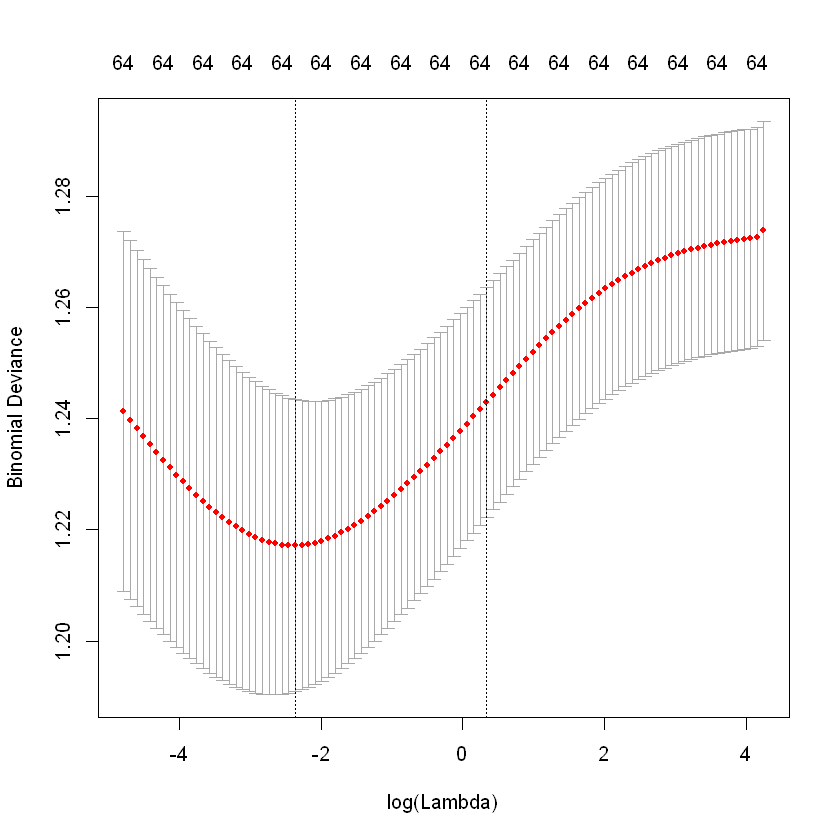

In [151]:
# ridge
# cv to find the best lambda
set.seed(1234)
cv.ridge <- cv.glmnet(train_x, train_y, alpha=0, family="binomial")
plot(cv.ridge)

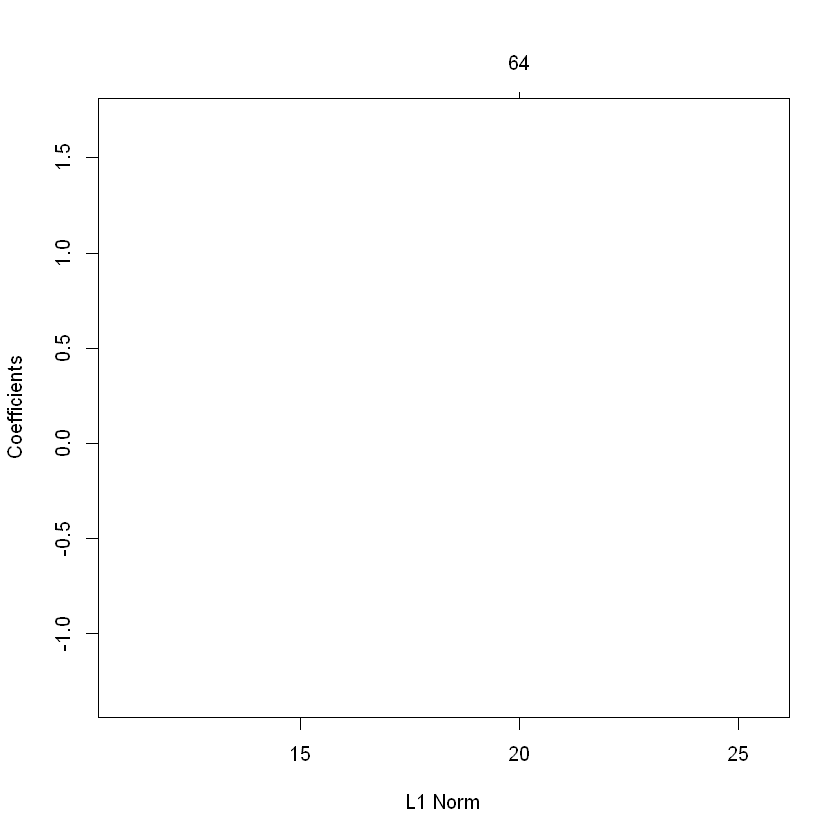

In [153]:
# final model with lambda min
ridge_mod1 <- glmnet(train_x, train_y, alpha=0, family="binomial", lambda = cv.ridge$lambda.min)
plot(ridge_mod1)

In [155]:
# make prediction on test data
ridge_preds <- predict(ridge_mod1, newx = test_x, type="response")
ridge_class <- ifelse(ridge_preds> 0.5, 1, 0)
# preds

#predictive accuracy, 2x2 table
table(ridge_class, test_y)

           test_y
ridge_class   0   1
          0 178  79
          1  12  14

In [156]:
mean(ridge_class==test_y)

[1] 0.6784452

In [180]:
## Tree type classification
library(rpart)

In [195]:
tree_mod1 <- rpart(Completed~., method="class", data=gardasil)
# summary(tree_mod1)

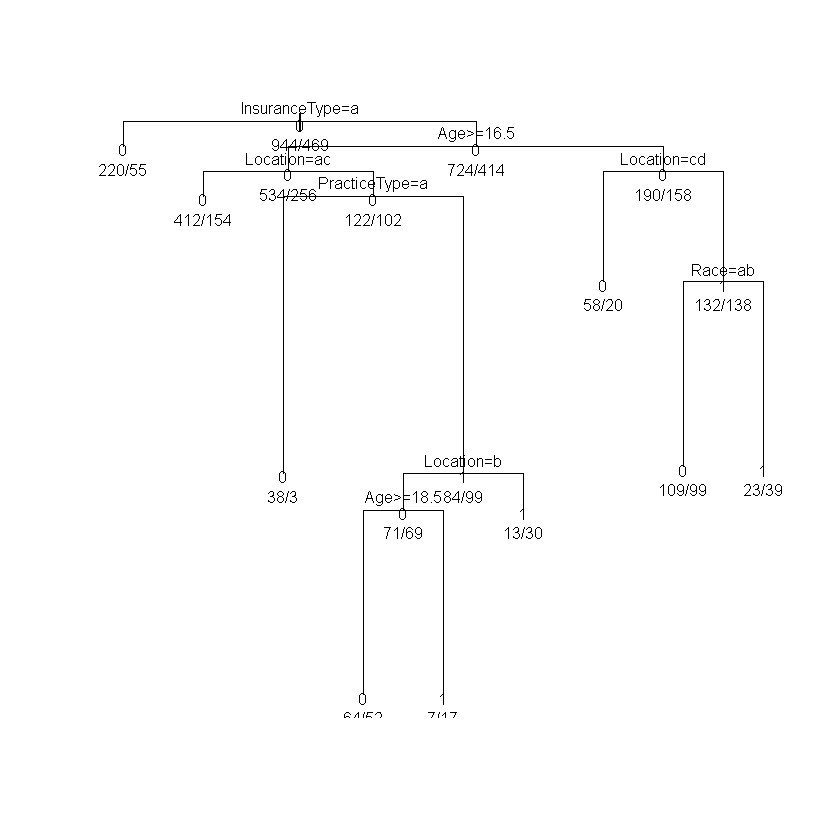

In [187]:
plot(tree_mod1)
text(tree_mod1, use.n=TRUE, all=TRUE, cex=.8)

In [190]:
# another tree
library(partykit)

Warning message:
"package 'partykit' was built under R version 3.6.3"Loading required package: grid
Loading required package: libcoin
Warning message:
"package 'libcoin' was built under R version 3.6.3"Loading required package: mvtnorm
Warning message:
"package 'mvtnorm' was built under R version 3.6.3"

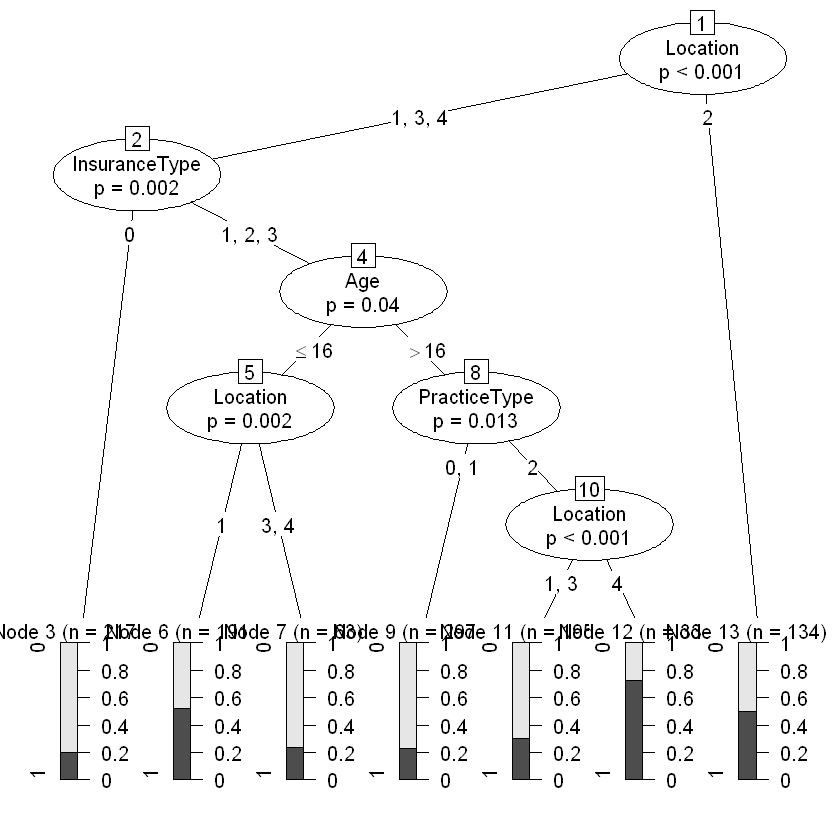

In [202]:
tree_mod2 <- ctree(Completed ~ .,data = train_df)
plot(tree_mod2)

In [201]:
tree_preds2 <- predict(tree_mod2, newdata=test_df, type="response")
# tree_class2 <- ifelse(tree_preds2>0.5, 1, 0)

table(tree_preds2, test_y)
mean(tree_preds2==test_y)

           test_y
tree_preds2   0   1
          0 155  59
          1  35  34

[1] 0.6678445

In [203]:
prop.table(table(tree_preds2, test_y), 2)

           test_y
tree_preds2         0         1
          0 0.8157895 0.6344086
          1 0.1842105 0.3655914

In [208]:
# try age group instead of age
gardasil_ag <- gardasil %>%
    mutate(Adult = as.factor(ifelse(Age<=17, 0, 1))) %>%
    select(-Age)
summary(gardasil_ag)

 Race    Completed InsuranceType Location PracticeType Adult  
 0:732   0:944     0:275         1:798    0:515        0:645  
 1:443   1:469     1:723         2:165    1:365        1:768  
 2: 52             2: 84         3: 89    2:533               
 3:186             3:331         4:361                        

In [211]:
train_ag <- gardasil[train_ids,]
test_ag <- gardasil[-train_ids,]

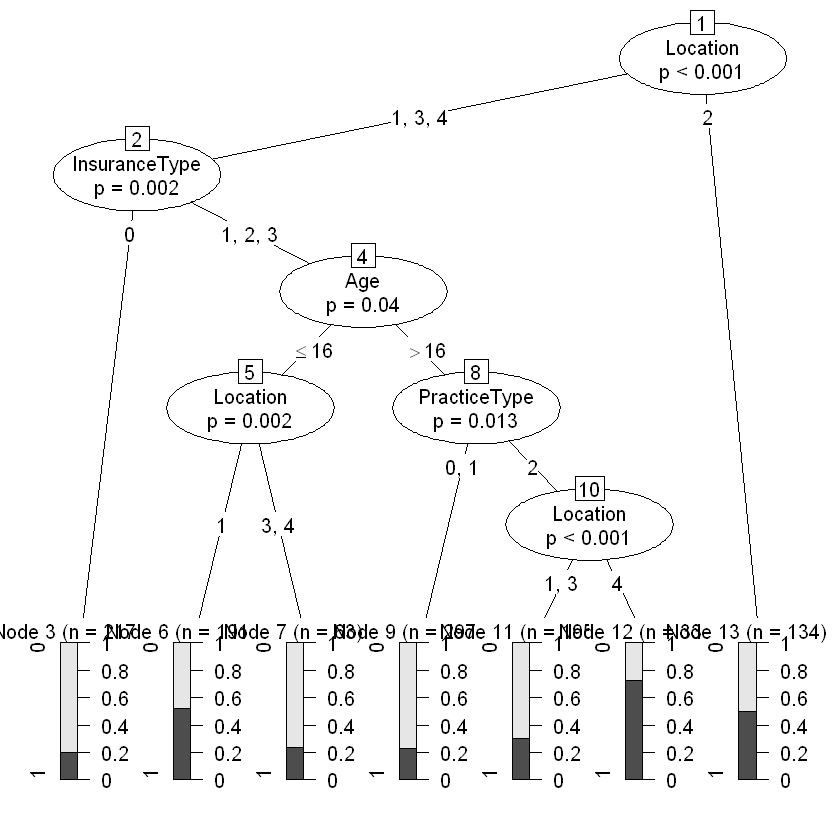

In [212]:
tree_mod3 <- ctree(Completed ~ .,data = train_ag)
plot(tree_mod3)